In [1]:
import numpy as np
from scipy.stats import entropy
from itertools import product
import pandas as pd
import utils
from collections import namedtuple
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
np.set_printoptions(precision=1)

In [2]:
from utils import counting

@counting
def onemax(x):
	return -sum(x)

@counting
def deceptive_onemax(x):
	return -( (sum(x) - 1) % (len(x) + 1) )

@counting
def kdeceptive_onemax(x, k = 4):
	dec = deceptive_onemax()
	def rec(x):
		if len(x) >= k: return dec(x)
		return rec(x[:len(x)//2]) + rec(x[len(x)//2:])
	return rec(x)

In [3]:
labels = ("min", "max", "mean", "calls")
State = namedtuple("State", labels)

def train(algorithm, f, max_evaluations = np.inf, **kwargs):
	F = f()
	A = algorithm(F, **kwargs)
	training_data = []
	utils.progress_bar
	while F.calls < max_evaluations:
		training_data.append(next(A))
	return pd.DataFrame.from_records(training_data, columns = labels)

## Mimic Implementation

In [4]:
def marginal_probabilities(X):
    return np.apply_along_axis(lambda x: np.bincount(np.int32(x), minlength=2), axis=1, arr=X.T) / len(X.T[0])

In [5]:
def relative_entropy(X):
    n = len(X.T); re = np.zeros((n, n))
    p = marginal_probabilities(X)
    for i,j in product(range(n), range(n)):
        re[i, j] = entropy(p[i], p[j])
    return re

In [6]:
def least_entropic(X):
    return np.argmin(np.apply_along_axis(entropy, axis=1, arr=marginal_probabilities(X)))

In [7]:
def conditional_probabilities(X):
    X = X.T
    n = len(X)
    probs = np.zeros((n, n))
    for i,j in product(range(n), range(n)):
        # P(i|j) = P(i, j) / P(j)
        Pij = np.bincount(X[i] * X[j], minlength=2)
        Pj = np.bincount(X[j], minlength=2)
        probs[i,j] = np.divide(Pij, Pj, where=Pj!=0)[1]
    return probs

In [8]:
def sample(order, probs):
    r = np.zeros_like(probs[0][0])

    j = order[0]
    test = 1
    for i in order:
        roll = np.random.random()
        test = int(roll <= probs[test][i, j])
        r[i] = test
        j = i
    return r

In [9]:
def sample_population(X, N):
    re = relative_entropy(X)
    root = least_entropic(X)
    
    order = [root]
    for _ in range(len(X[0]) - 1):
        s = np.argsort(re[:, order[-1]])
        i = next(filter(lambda x: x not in order, s))
        order.append(i)

    p1 = conditional_probabilities(X)
    p0 = 1 - conditional_probabilities(-X + 1)

    np.fill_diagonal(p1, marginal_probabilities(X)[:, 1])

    probs = [p0, p1]

    population = np.zeros((N, len(X[0])), dtype=np.int64)
    for i in range(N):
        population[i] = sample(order, probs)
    return population, order

In [10]:
def select(population, fitness, theta):
    return population[fitness <= theta]

In [11]:
labels = ("best", "worst", "mean", "calls")
State = namedtuple("State", labels)

def MIMIC(F, N=100, P=50, n=5, verbose=False):
    """Minimize fitness function F"""
    population = np.random.randint(0, 2, (N, n))
    fitness = np.apply_along_axis(F, 1, population)
    theta = np.percentile(fitness, 50)

    while True:
        selection = select(population, fitness, theta)
        population, order = sample_population(selection, N)
        fitness = np.apply_along_axis(F, 1, population)
        theta = np.percentile(fitness, P)
        yield State(np.min(fitness), np.max(fitness), np.average(fitness), F.calls)
        if verbose: clear_output(wait=True); print(order)


## Benchmarks

In [12]:
def test(algorithm, f, max_evaluations = 10000, cases = 10, **kwargs):
	calls = []
	mn = []
	mx = []
	mean = []
	for i in range(cases):
		data = train(algorithm, f, max_evaluations, **kwargs)
		calls.append(data["calls"].to_numpy())
		mn.append(-data["best"].to_numpy())
		mx.append(-data["worst"].to_numpy())
		mean.append(-data["mean"].to_numpy())
	return np.mean(calls, axis=0), np.mean(mn, axis=0), np.mean(mx, axis=0), np.mean(mean, axis=0)

In [17]:
calls, b, w, m = test(MIMIC, kdeceptive_onemax, max_evaluations=20000, N = 1000, n = 16, verbose = True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


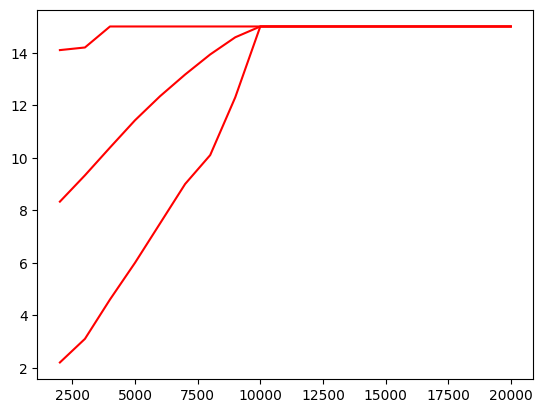

In [18]:
plt.plot(calls, b, "r-")
plt.plot(calls, w, "r-")
plt.plot(calls, m, "r-")
plt.show()

In [20]:
calls, b, w, m = test(MIMIC, kdeceptive_onemax, max_evaluations=80000, N = 1000, n = 32, verbose = True)

[0, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 30, 31]


In [21]:
calls, b, w, m = test(MIMIC, kdeceptive_onemax, max_evaluations=80000, N = 1000, n = 64, verbose = True)

[0, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 33, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 48, 32, 31, 30, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 62, 63]


In [24]:
calls, b, w, m = test(MIMIC, kdeceptive_onemax, max_evaluations=10000, N = 500, n = 256)

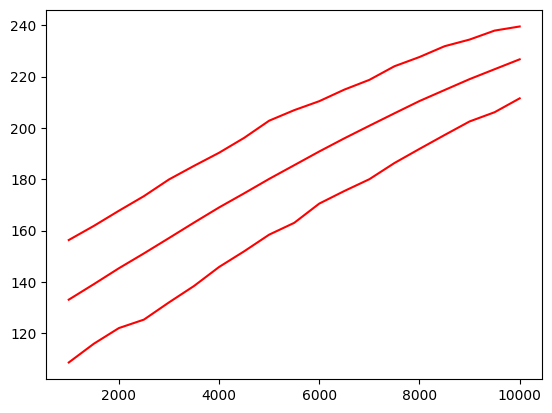

In [25]:
plt.plot(calls, b, "r-")
plt.plot(calls, w, "r-")
plt.plot(calls, m, "r-")
plt.show()